In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import os
import sys
import random
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import torchvision.transforms as T
import torchvision
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.models import resnet50
from torch.utils.data import ConcatDataset, DataLoader

In [4]:
%autoreload 2
from utils.general import imshow

In [90]:
def normalize_image(image: torch.Tensor) -> torch.Tensor:
    image = image / 255
    return T.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


def unnormalize_image(image: torch.Tensor) -> torch.Tensor:
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    return T.functional.normalize(image, (-mean / std).tolist(), (1.0 / std).tolist())


def resize_image(image: torch.Tensor, image_resize_size: int) -> torch.Tensor:
    return T.functional.resize(image, (image_resize_size, image_resize_size))


def cut_image(image: torch.Tensor, threshold: float = 0.05, min_gray: float = 0.05)-> torch.Tensor:
    gray_image = T.functional.rgb_to_grayscale(image) / 255

    # Threshold the grayscale image
    binary_mask = (gray_image > threshold).int()[0]
    cols = torch.mean(binary_mask.float(), dim=0).float() > min_gray
    left, right = torch.min(torch.where(cols)[0]), torch.max(torch.where(cols)[0])

    rows = torch.mean(binary_mask.float(), dim=1).float() > min_gray
    top, bottom = torch.min(torch.where(rows)[0]), torch.max(torch.where(rows)[0])

    # Crop the image based on the contour boundaries
    return image[:, top:bottom, left:right]


def pad_to_square(image: torch.Tensor) -> torch.Tensor:
    _, width, height = image.shape

    # Determine the maximum dimension
    max_dim = max(width, height)

    # Calculate the padding amounts
    pad_width = max_dim - width
    pad_height = max_dim - height

    # Calculate the padding values for top, bottom, left, and right
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # Pad the image with zeros
    return torch.nn.functional.pad(image, (pad_top, pad_bottom, pad_left, pad_right))


def process_image(image_path: str, image_resize_size: int) -> torch.Tensor:
    image_raw = torchvision.io.read_image(image_path)
    cropped_image = cut_image(image_raw)
    padded_image = pad_to_square(cropped_image)
    resized_image = resize_image(padded_image, image_resize_size)
    return resized_image

In [35]:
labels_path = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/archive/trainLabels.csv'
labels_df = pd.read_csv(labels_path)
labels_df[['id', 'left_or_right']] = labels_df['image'].str.split('_', expand=True)

# Drop the original "image" column
labels_df.drop('image', axis=1, inplace=True)
labels_df.head(10)

labels_df[(labels_df['id'] == '10') & (labels_df['left_or_right'] == 'left')]['level'].item()

0

In [84]:
image_dir = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/archive/train/split_001'
save_dir = '/home/ludwig-graef/Workplace/Master_Thesis/Datasets/Fundus_01/data'

for image_file_name in os.listdir(image_dir)[:2000]:
    id, left_or_right = image_file_name.split('_')
    left_or_right = left_or_right.split('.')[0]
    class_label = labels_df[(labels_df['id'] == id) & (labels_df['left_or_right'] == left_or_right)]['level'].item()

    save_dir_image = os.path.join(save_dir, left_or_right, f'class_{class_label}')
    save_path_image = os.path.join(save_dir_image, f'{id}.jpeg')
    image_path = os.path.join(image_dir, image_file_name)
    os.makedirs(save_dir_image, exist_ok=True)

    image = process_image(image_path, image_resize_size=224)
    torchvision.utils.save_image(image / 255, save_path_image)
    # imshow(image)
    # break

/home/ludwig-graef/Workplace/Programs/miniconda3/envs/m_t/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [92]:
dataset_right = ImageFolder(os.path.join(save_dir, 'right'), loader=torchvision.io.read_image)
dataset_left = DatasetFolder(os.path.join(save_dir, 'left'), torchvision.io.read_image, extensions='.jpeg')
dataset = ConcatDataset([dataset_right, dataset_left])

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [111]:
model = resnet50(pretrained=True).to(device)

# Remove the last layer and freeze the weights
model = nn.Sequential(*list(model.children())[:-1])
for param in model.parameters():
    param.requires_grad = False

dataloader = DataLoader(dataset, batch_size=16)

embeddings_complete, labels_complete = [], []
for images, labels in dataloader:
    with torch.no_grad():
        embeddings = model(normalize_image(images.to(device))).squeeze()
    embeddings_complete.extend(embeddings)
    labels_complete.extend(labels)

/home/ludwig-graef/Workplace/Programs/miniconda3/envs/m_t/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ludwig-graef/Workplace/Programs/miniconda3/envs/m_t/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
embeddings_tensor = torch.stack(embeddings_complete).to(device)
labels_tensor = torch.stack(labels_complete).to(device)

In [94]:
import torch
from torch import nn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

In [141]:
def train_linear_model(embeddings: torch.Tensor, labels: torch.Tensor, device) -> nn.Module:
    # Train a linear model
    linear_model = nn.Linear(embeddings.shape[1], len(torch.unique(labels))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(linear_model.parameters(), lr=3e-4)

    # Training loop
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = linear_model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return linear_model

def plot_roc_curve(labels: List[int], scores: List[float]):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

2000 2000


/tmp/ipykernel_16357/31095354.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = nn.functional.softmax(linear_model(embeddings_tensor)).detach().cpu().numpy()


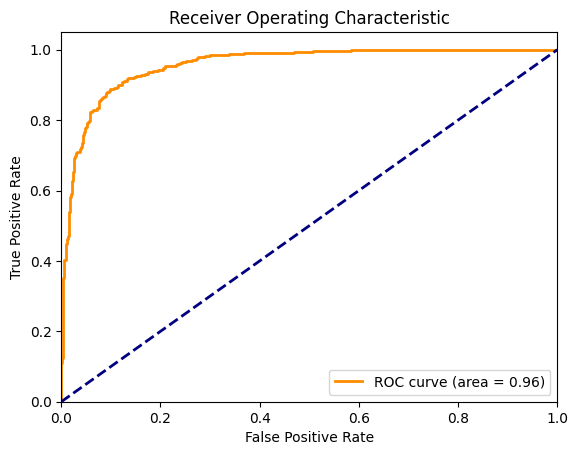

2000 2000


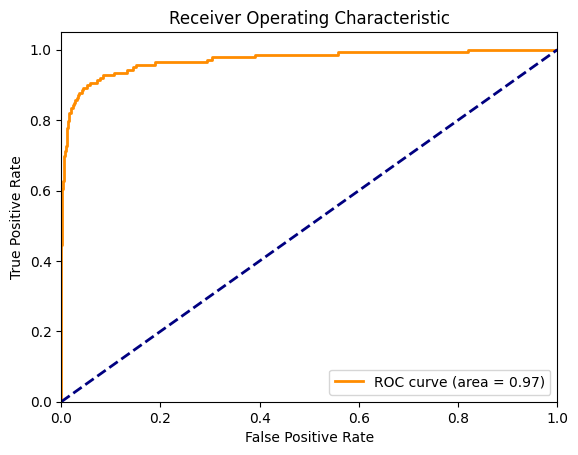

2000 2000


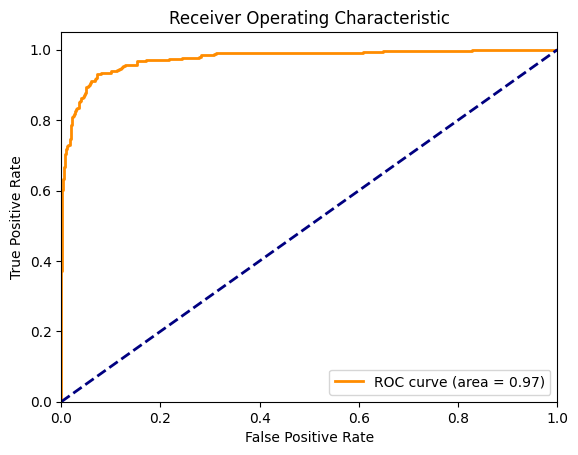

2000 2000


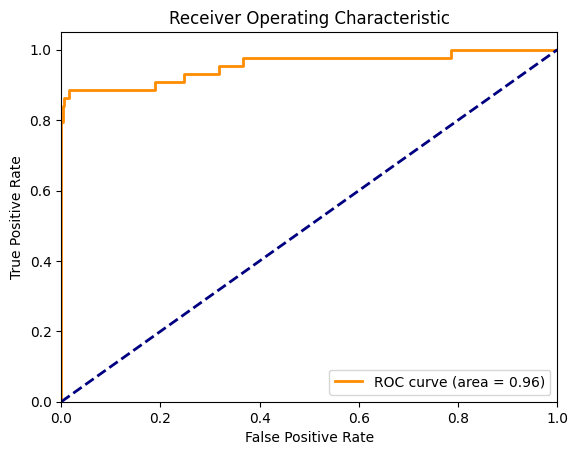

2000 2000


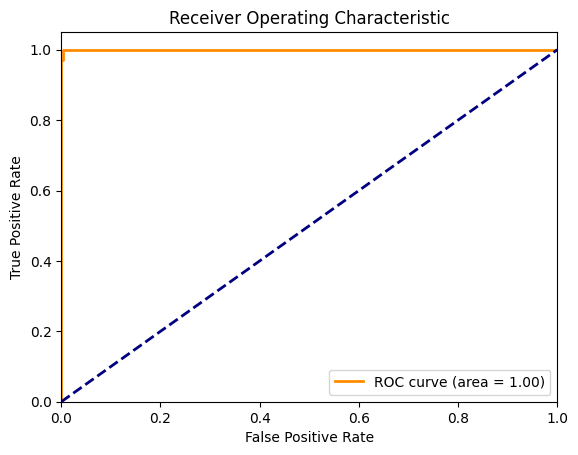

In [142]:
# Train a linear model
linear_model = train_linear_model(embeddings_tensor, labels_tensor, device)

# Calculate scores using the linear model
scores = nn.functional.softmax(linear_model(embeddings_tensor)).detach().cpu().numpy()
# Plot ROC curve for each class
for class_label in torch.unique(labels_tensor):
    class_scores = scores[:, class_label]
    class_labels = [1 if label == class_label else 0 for label in labels_tensor]
    plot_roc_curve(class_labels, class_scores)